## Sentiment Classification: classifying IMDB reviews

In this task, you will learn how to process text data and how to train neural networks with limited input text data using pre-trained embeddings for sentiment classification (classifying a review document as "positive" or "negative" based solely on the text content of the review).

We will use the `Embedding` layer in Keras to represent text input. The `Embedding` layer is best understood as a dictionary mapping integer indices (which stand for specific words) to dense vectors. It takes as input integers, then looks up these integers into an internal dictionary, and finally returns the associated vectors. It's effectively a dictionary lookup.

The `Embedding` layer takes as input a 2D tensor of integers, of shape `(samples, sequence_length)`, where each entry is a sequence of integers. It can embed sequences of variable lengths, so for instance we could feed into our embedding layer above batches that could have  shapes `(32, 10)` (batch of 32 sequences of length 10) or `(64, 15)` (batch of 64 sequences of length 15). All sequences in a batch must have the same length, though (since we need to pack them into a single tensor), so sequences that are shorter than others should be padded with zeros, and sequences that are longer should be truncated.

This layer returns a 3D floating point tensor, of shape `(samples, sequence_length, embedding_dimensionality)`. Such a 3D tensor can then be processed by a RNN layer or a 1D convolution layer.

You can instantiate the `Embedding` layer by randomly initialising its weights (its internal dictionary of token vectors). During training, these word vectors will be gradually adjusted via backpropagation, structuring the space into something that the downstream model can exploit. Once fully trained, your embedding space will show a lot of structure -- a kind of structure specialized for the specific problem you were training your model for. You can also instantiate the `Embedding` layer by intialising its weights using the pre-trained word embeddings, such as GloVe word embeddings pretrained from Wikipedia articles.

#### a) Download the IMDB data as raw text

First, create a "data" directory, then head to `http://ai.stanford.edu/~amaas/data/sentiment/` and download the raw IMDB dataset (if the URL isn't working anymore, just Google "IMDB dataset"). Save it into the "data" directory. Uncompress it. Store the individual reviews into a list of strings, one string per review, and also collect the review labels (positive / negative) into a separate `labels` list.

In [70]:
import os
import random
import numpy as np
# write your code here

train_l=[]
test_l=[]
tk=[] #contains both trainging and testing datasets

#read the files in the train folder and label them according to subfolder
train_path='data/aclImdb/train/'
#2000 reviews half positive and half negative
train_pos_filenames = [train_path+'pos/'+i for i in os.listdir(train_path+'pos')][:10000]
train_neg_filenames= [train_path+'neg/'+i for i in os.listdir(train_path+'neg')][:10000]
for i in range(2*len(train_pos_filenames)):
    if i%2==0:
        t=train_pos_filenames
        label=0
    else:
        t=train_neg_filenames
        label=1
    with open(t[i//2], 'r') as f:
        text=f.read()
        train_l.append((text,label))
        tk.append(text)

        
#read the files in the test folder and label them according to subfolder
test_path='data/aclImdb/test/'
#2000 reviews half positive and half negative
test_pos_filenames = [test_path+'pos/'+i for i in os.listdir(test_path+'pos')][:1000]
test_neg_filenames= [test_path+'neg/'+i for i in os.listdir(test_path+'neg')][:1000]
for i in range(2*len(test_pos_filenames)):
    if i%2==0:
        t=test_pos_filenames
        label=0
    else:
        t=test_neg_filenames
        label=1
    with open(t[i//2], 'r') as f:
        text=f.read()
        test_l.append((text,label))
        tk.append(text)

#shuffle samples
random.shuffle(train_l)
random.shuffle(test_l)

#split training into training and validation
train_x, train_y = zip(*train_l)
test_x, test_y = zip(*test_l)
valid_x,valid_y=train_x[:len(train_x)*1//10],train_y[:len(train_y)*1//10]
train_x,train_y=train_x[len(train_x)*1//10:],train_y[len(train_y)*1//10:]

#transform outputs to numpy arrays 
train_y=np.array(train_y)
valid_y=np.array(valid_y)
test_y=np.array(test_y)
#inputs will undergo more processing first


#### b) Pre-process the review documents 

Pre-process review documents by tokenisation and split the data into the training and testing sets. You can restrict the training data to the first 1000 reviews and only consider the top 5,000 words in the dataset. You can also cut reviews after 100 words (that is, each review contains a maximum of 100 words).

In [71]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import scipy

# write your code here

#the list was compiled by first looking into the words with the top tfidf rates
#removed words indicating negation(e.g. not) and exagration(e.g. very) from list 
stopwords=['the', 'and', 'of', 'to', 'is', 'br', 'it', 'in', 'this', 'that', 'was','with', 'as', 'for', 'you', 
'on', 'are', 'he', 'have', 'his', 'be', 'one', 'at', 'they', 'all', 'who', 'by', 'from', 'so', 'an', 'off',
'there', 'her', 'if','out', 'or', 'about', 'just', 'has', 'what', 'can', 'some', 'when', 'she', 'up', 'my',
'their', 'which', 'me', 'were', 'had', 'we', 'well', 'get', 'than', 'because', 'will', 'did', 'your','over'
'been', 'its', 'other', 'do', 'also', 'into''him', 'how', 'too', 'them', 'after', 'any', 'then', 'before','those']

#find the top 5000 words with the highest avg tdidf scores across all reviews
tfidf = TfidfVectorizer(max_features=5000, stop_words=stopwords)
idf=tfidf.fit_transform(tk)
#transform idf matrix into a 2d matrix and list the mean tdidf for each word
words_tdidf=idf.todense().mean(axis=0).tolist()[0]
#match each tdidf score with the word and put in a list of tuples
top_tokens=sorted(tfidf.vocabulary_)
d=list(zip(top_tokens,words_tdidf))

#initilise tokenizer and set word_counts attributes and word_index
token=Tokenizer()

token.word_counts=d #replace word counts with word tdidf score 
token.word_index=tfidf.vocabulary_ #set tokeniser vocubulary to idf vocabulary

#transform text to sequence of strings
tk_train_x=token.texts_to_sequences(train_x)
tk_valid_x=token.texts_to_sequences(valid_x)
tk_test_x=token.texts_to_sequences(test_x)

#pad the input to have 100 items 
tk_train_x=pad_sequences(tk_train_x, maxlen = 100, padding = "post", truncating = "post", value = 0)
tk_valid_x=pad_sequences(tk_valid_x, maxlen = 100, padding = "post", truncating = "post", value = 0)
tk_test_x=pad_sequences(tk_test_x, maxlen = 100, padding = "post", truncating = "post", value = 0)



MemoryError: 

# c) Download the GloVe word embeddings and map each word in the dataset into its pre-trained GloVe word embedding.


First go to `https://nlp.stanford.edu/projects/glove/` and download the pre-trained 
embeddings from 2014 English Wikipedia into the "data" directory. It's a 822MB zip file named `glove.6B.zip`, containing 100-dimensional embedding vectors for 
400,000 words (or non-word tokens). Un-zip it.

Parse the un-zipped file (it's a `txt` file) to build an index mapping words (as strings) to their vector representation (as number vectors).

Build an embedding matrix that will be loaded into an `Embedding` layer later. It must be a matrix of shape `(max_words, embedding_dim)`, where each entry `i` contains the `embedding_dim`-dimensional vector for the word of index `i` in our reference word index 
(built during tokenization). Note that the index `0` is not supposed to stand for any word or token -- it's a placeholder.

In [ ]:
# write your code here

#initialise glove file path and embedding matrix 
glove_path='./glove.6B.100d.txt'
wn=len(top_tokens)+1
embed_matrix=np.zeros((wn,100))

#open glove text file and save it to content
with open(glove_path, encoding="utf8" ) as f:
    content = f.readlines()
    
#for each line check if word in list of top words 
#if it is then add the word embedding 100d vector to the embed_matrix
for line in content:
    splitLine = line.split()
    word = splitLine[0]
    if word in top_tokens:
        index=top_tokens.index(word)
        embedding = np.asarray(splitLine[1:])
        embed_matrix[index+1] = embedding




#### d) Build and train a simple Sequential model

The model contains an Embedding Layer with maximum number of tokens to be 10,000 and embedding dimensionality as 100. Initialise the Embedding Layer with the pre-trained GloVe word vectors. Set the maximum length of each review to 100. Flatten the 3D embedding output to 2D and add a Dense Layer which is the classifier. Train the model with a 'rmsprop' optimiser. You need to freeze the embedding layer by setting its `trainable` attribute to `False` so that its weights will not be updated during training.

In [45]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Dense, Input, 

# write your code here

#create the imbed layer with the weights defined by the embedidng matrix and trainable attribute to false
embed_layer = Embedding(input_dim=embed_matrix.shape[0],output_dim=embed_matrix.shape[1], 
                        input_length=100, weights=[embed_matrix],trainable=False, mask_zero=False)

#create a sequential network model with embedding layer and a feedforeward layer with 32 neurons
i = Input(shape=(100,), dtype='int32')
x = embed_layer(i)
x = Flatten()(x)
o = Dense(1, activation='sigmoid')(x)

model = Model(inputs=i, outputs=o)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
# fit network
model.summary()

history = model.fit(tk_train_x, train_y, verbose=1, batch_size=32, epochs=20,
                    validation_data=(tk_valid_x, valid_y))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 100, 100)          500100    
_________________________________________________________________
flatten_13 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 820,165
Trainable params: 320,065
Non-trainable params: 500,100
_________________________________________________________________
Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 [==============================] - 3s 2ms/step - loss: 0.7240 

#### e) Plot the training and validation loss and accuracies and evaluate the trained model on the test set.

What do you observe from the results?

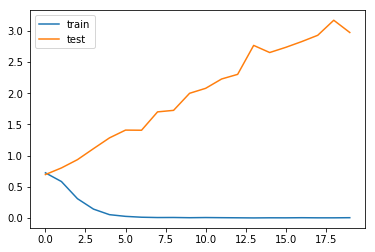

              precision    recall  f1-score   support

           0       0.49      0.48      0.49      1000
           1       0.50      0.51      0.50      1000

   micro avg       0.49      0.49      0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000

0.495


In [46]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

# write your code here
#plot training and validation loss and accuracy histoties
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#predict the sentiment for test dataset and print the classification report 
pred_test_y=model.predict(np.array(tk_test_x), batch_size=32)
print(classification_report(test_y,pred_test_y.round()))
print(accuracy_score(test_y,pred_test_y.round()))

#from the results we see that the network overfits grossly on the training data 

#### f) Add an LSTM layer into the simple neural network architecture and re-train the model on the training set, plot the training and validation loss/accuracies, also evaluate the trained model on the test set and report the result.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 100)               0         
_________________________________________________________________
embedding_36 (Embedding)     (None, 100, 100)          500100    
_________________________________________________________________
lstm_22 (LSTM)               (None, 24)                12000     
_________________________________________________________________
dropout_16 (Dropout)         (None, 24)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 25        
Total params: 512,125
Trainable params: 12,025
Non-trainable params: 500,100
_________________________________________________________________
Train on 1800 samples, validate on 200 samples
Epoch 1/20
1800/1800 [==============================] - 30s 17ms/step - loss: 4.1147

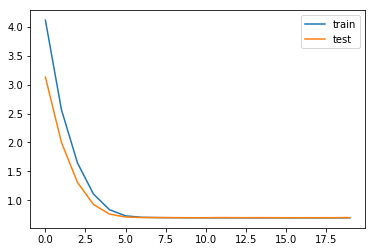

              precision    recall  f1-score   support

           0       0.49      0.02      0.04      1000
           1       0.50      0.98      0.66      1000

   micro avg       0.50      0.50      0.50      2000
   macro avg       0.49      0.50      0.35      2000
weighted avg       0.49      0.50      0.35      2000

0.4995


In [69]:
from keras.layers import LSTM, regularizers, Dropout

# write your code here
embed_layer = Embedding(input_dim=embed_matrix.shape[0],output_dim=embed_matrix.shape[1], 
                        input_length=100, weights=[embed_matrix],trainable=False, mask_zero=True)


#create a sequential network model with embedding layer and a LSTM layer with 32 neurons
#adding weights regulizer and dropout to limit overfitting
i = Input(shape=(100,), dtype='int32')
x = embed_layer(i)
x = LSTM(24, kernel_regularizer = regularizers.l2(l = 0.05))(x)
x =Dropout(0.4)(x)
#x = Flatten()(x)
o = Dense(1,activation='sigmoid')(x)

model = Model(inputs=i, outputs=o)
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
model.summary()

# fit network
history = model.fit(tk_train_x, train_y, verbose=1, batch_size=64, epochs=20,
                    validation_data=(tk_valid_x, valid_y))

#plot training and validation loss and accuracy histoties
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

#predict the sentiment for test dataset and print the classification report 
pred_test_y=model.predict(np.array(tk_test_x), batch_size=32)
print(classification_report(test_y,pred_test_y.round()))
print(accuracy_score(test_y,pred_test_y.round()))